# Supertrend Strategy Setup

- **Date range**: 05/27/2007 to 05/27/2024
- **Frequency**: Daily
- **Dataset includes**: MSFT, AMZN, CSCO, TXN
- **Source**: Historical prices acquired from Yahoo Finance
- **Train set**: 05/27/2007 - 05/27/2020
- **Test set**: 05/27/2020 - 05/27/2024


# **Imports**

In [ ]:
!pip install panda
!pip install numpy
!pip install matplotlib
!pip install yfinance
!pip install mplfinance
!pip install scikit-optimize
!pip install bayesian-optimization

  Preparing metadata (setup.py) ... done
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=58b3dfb8f96e90b6cc6575009014dff3b7ab6a72a07827af2e7e67ccd3184fe2
  Stored in directory: /root/.cache/pip/wheels/0e/8b/c3/ff9cbde1fffd8071cff8367a86f0350a1ce30a8d31b6a432e9
Successfully built panda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=ac5c5071d9ebe7b5dafe3e23bae7b4027e08b82d46b83d505dfaa49c7be52b26
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bayes_opt import BayesianOptimization
from datetime import datetime
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
import mplfinance as mpf
import pandas_ta as ta

# **Helper Functions**

In [ ]:
def fetch_asset_data(symbol, start_date, end_date):
    """
    Fetches historical OHLCV (Open, High, Low, Close, Volume) data for a given asset symbol
    within a specified date range, calculates daily returns, and returns the processed data.

    Parameters:
    symbol (str): The ticker symbol of the asset (e.g., 'AAPL' for Apple Inc.).
    start_date (str): The start date for the data fetch in the format 'YYYY-MM-DD'.
    end_date (str): The end date for the data fetch in the format 'YYYY-MM-DD'.

    Returns:
    pandas.DataFrame: A DataFrame containing the OHLCV data with an additional column for
                      daily returns. Rows with missing values are dropped.
    """
    # Fetch OHLCV data using yfinance
    asset_data = yf.download(symbol, start=start_date, end=end_date)
    # Calculate daily returns as the percentage change in 'Close' price from the previous day
    asset_data['Daily Return'] = asset_data['Close'].pct_change()
    # Drop any rows with missing values
    asset_data.dropna(inplace=True)
    return asset_data


In [ ]:
def calculate_cumulative_returns(daily_returns):
    return (1 + daily_returns).cumprod()

Define Supertrend and RSI

### **Define `supertrend` Function**

The `supertrend` function calculates the Supertrend indicator for a given DataFrame `df` containing historical OHLC (Open, High, Low, Close) data. The function requires two parameters: the ATR (Average True Range) period (`atr_period`) and the ATR multiplier (`atr_multiplier`). The Supertrend indicator helps identify market trends by combining price action and volatility.

### Steps and Calculations:

1. **Calculate Current Average High and Low:**
```python
current_average_high_low = (df['High'] + df['Low']) / 2
```
This computes the average of the high and low prices for each period.

2. **Calculate True Range (TR):**
```python
df['tr1'] = df['High'] - df['Low']
df['tr2'] = abs(df['High'] - df['Close'].shift())
df['tr3'] = abs(df['Low'] - df['Close'].shift())
df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
```
The True Range is the maximum of:
- Current high minus current low
- Absolute value of current high minus previous close
- Absolute value of current low minus previous close

3. **Calculate Average True Range (ATR):**
```python
df['atr'] = df['tr'].rolling(window=atr_period).mean()
```
The ATR is the rolling mean of the True Range over the specified `atr_period`.


4. **Calculate Basic Upper and Lower Bands:**
```python
df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
```
The basic bands are calculated using the average high-low price and the ATR multiplied by the specified `atr_multiplier`.

5. **Initialize Upper and Lower Bands:**
```python
first_upperBand_value = df['basicUpperband'].iloc[0]
first_lowerBand_value = df['basicLowerband'].iloc[0]
upperBand = [first_upperBand_value]
lowerBand = [first_lowerBand_value]
```
The initial values of the upper and lower bands are set to the first values of the basic bands.

6. **Compute Final Upper and Lower Bands:**
```python
for i in range(1, len(df)):
    if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['Close'].iloc[i-1] > upperBand[i-1]:
        upperBand.append(df['basicUpperband'].iloc[i])
    else:
        upperBand.append(upperBand[i-1])

    if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['Close'].iloc[i-1] < lowerBand[i-1]:
        lowerBand.append(df['basicLowerband'].iloc[i])
    else:
        lowerBand.append(lowerBand[i-1])
```
The final bands are computed iteratively, ensuring that they are adjusted based on previous values and the current closing price.

7. **Add Final Bands to DataFrame:**
```python
df['upperband'] = upperBand
df['lowerband'] = lowerBand
```
The final upper and lower bands are added to the DataFrame.

8. **Calculate Relative Strength Index (RSI):**
```python
df['RSI'] = ta.rsi(df['Close'], length=14)
```
An additional RSI (Relative Strength Index) is calculated for potential use in further analysis or trading strategy.


In [ ]:
def supertrend(df, atr_period, atr_multiplier):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formula: Supertrend = (High + Low) / 2 + (Multiplier) * (ATR)
    current_average_high_low = (df['High'] + df['Low']) / 2

    # Calculate True Range (TR)
    df['tr1'] = df['High'] - df['Low']
    df['tr2'] = abs(df['High'] - df['Close'].shift())
    df['tr3'] = abs(df['Low'] - df['Close'].shift())
    df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

    # Calculate ATR
    df['atr'] = df['tr'].rolling(window=atr_period).mean()

    # Drop temporary columns
    df.drop(['tr1', 'tr2', 'tr3', 'tr'], axis=1, inplace=True)

    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['Close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['Close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband'], axis=1, inplace=True)

    df['RSI'] = ta.rsi(df['Close'], length=14)

    return df

This code calculates the percentage of days the closing price stays within the calculated upper and lower Supertrend bands for a given dataset.

In [ ]:
def calculate_percentage_within_bands(df):
    """
    Checks each day if the close price is between the upper and lower bands
    and calculates the percentage of days the close price remains within these bands.
    """
    # Create a mask where the close price is between the bands
    within_bands = (df['Close'] >= df['lowerband']) & (df['Close'] <= df['upperband'])
    # Calculate the percentage of days within the bands
    percentage_within = within_bands.mean() * 100
    return percentage_within

# Fetch historical data for Apple Inc.
data = yf.download('AAPL', start='2020-01-01', end='2024-06-01')

# Apply Supertrend
supertrend_data = supertrend(data, atr_period=15, atr_multiplier=4.344)

# Calculate the percentage of days the close price is within the bands
percentage = calculate_percentage_within_bands(supertrend_data)
print(f"Percentage of price within the bands: {percentage:.2f}%")


[*********************100%%**********************]  1 of 1 completed

Percentage of price within the bands: 95.90%


### **Define `generate_signals` Function**

The `generate_signals` function generates trading signals based on the Supertrend indicator and the Relative Strength Index (RSI). The function analyzes the DataFrame `df` to determine when to enter or exit long and short positions.



1. **No Existing Position (position == 0):**
   ```python
   if position == 0:
   ```
   - **Enter Short Position:**
     ```python
     if df['Close'][i] > df['upperband'][i] and df['RSI'][i] > 70:
         position = -1
     ```
     Enter a short position if the close price is above the upper band and RSI is greater than 70 (overbought condition).
   - **Enter Long Position:**
     ```python
     elif df['Close'][i] < df['lowerband'][i] and df['RSI'][i] < 30:
         position = 1
     ```
     Enter a long position if the close price is below the lower band and RSI is less than 30 (oversold condition).
   - **Short Position Within Bands:**
     ```python
     if df['Close'][i] > df['lowerband'][i] and df['Close'][i] < df['middle'][i]:
         position = 1
     ```
     Enter a short position if the close price is between the lower band and the middle band.
   - **Long Position Within Bands:**
     ```python
     elif df['Close'][i] < df['upperband'][i] and df['Close'][i] > df['middle'][i]:
         position = -1
     ```
     Enter a long position if the close price is between the upper band and the middle band.

2. **Currently in a Short Position (position == -1):**
   ```python
   elif position == -1:
       if df['Close'][i] <= df['middle'][i]:
           position = 0
       else:
           position = -1
   ```
   Exit the short position if the close price is less than or equal to the middle band, otherwise maintain the short position.

3. **Currently in a Long Position (position == 1):**
   ```python
   elif position == 1:
       if df['Close'][i] >= df['middle'][i]:
           position = 0
       else:
           position = 1
   ```
   Exit the long position if the close price is greater than or equal to the middle band, otherwise maintain the long position.


In [ ]:
def generate_signals(df):
    # Initialize a signals list with a default of 0
    signals = [0] * len(df)

    # Initialize position
    position = 0
    df['middle'] = (df['lowerband']+df['upperband'])/2

    # Loop through the dataframe
    for i in range(1, len(df)):
        if position == 0:  # No existing position

            if df['Close'][i] > df['upperband'][i] and df['RSI'][i]>70:
                position = -1  # Enter short position
            elif df['Close'][i] < df['lowerband'][i]and df['RSI'][i]<30:
                position = 1  # Enter long position

            if df['Close'][i] > df['lowerband'][i] and df['Close'][i] < df['middle'][i]:
                position = 1  # Enter short position
            elif df['Close'][i] < df['upperband'][i]and df['Close'][i] > df['middle'][i]:
                position = -1  # Enter long position

        elif position == -1:  # Currently in a short position
            if df['Close'][i] <= df['middle'][i]:
                position = 0  # Exit short position
            else:
                position == -1
        elif position == 1:  # Currently in a long position
            if df['Close'][i] >= df['middle'][i]:
                position = 0  # Exit long position
            else:
                position == 1

        # Assign the current position to signals
        signals[i] = position

    # Add the signals list as a new column in the dataframe
    df['signals'] = signals
    df['signals'] = df['signals'].shift(1)  # Remove look-ahead bias
    df.dropna(inplace=True)
    return df

### **Define `strategy` and `calculate_metrics` Function**

In [ ]:
def strategy(df):
    """
    Calculates the performance of the trading strategy based on the generated signals.
    The function multiplies the position signals with daily returns to compute the cumulative performance.
    """
    strategy_result = pd.DataFrame()
    strategy_result['position'] = df['signals']
    strategy_result['performance'] = (1 + strategy_result['position'] * df['Daily Return']).cumprod()
    return strategy_result

def calculate_metrics(cumret, ticker):
    """
    Calculate performance metrics from cumulative returns for a specified ticker and return them in a structured format.
    The metrics include total return, annualized return, Sharpe ratio, maximum drawdown, and maximum drawdown duration.
    """
    total_return = (cumret[-1] - cumret[0]) / cumret[0]
    apr = (1 + total_return) ** (252 / len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # Calculate max drawdown and max drawdown duration
    highwatermark = np.zeros_like(cumret)
    drawdown = np.zeros_like(cumret)
    drawdownduration = np.zeros_like(cumret)

    highwatermark[0] = cumret[0]
    for t in range(1, len(cumret)):
        highwatermark[t] = max(highwatermark[t-1], cumret[t])
        drawdown[t] = cumret[t] / highwatermark[t] - 1
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1

    maxDD = np.min(drawdown)
    maxDDD = np.max(drawdownduration)

    # Creating a structured performance matrix as a dictionary
    performance_matrix = {
        'Ticker': ticker,
        'Total Return': total_return,
        'Annualized Return (APR)': apr,
        'Sharpe Ratio': sharpe,
        'Maximum Drawdown': maxDD,
        'Maximum Drawdown Duration': maxDDD
    }
    for key, value in performance_matrix.items():
        print(f'{key}: {value}')

    return performance_matrix


### **Define `run_strategy_dynamic` Function**

In [ ]:
def run_strategy_dynamic(symbol, test_start_date, test_end_date, atr_period, atr_multiplier):
    # Adjust test_start_date to subtract atr_period
    adjusted_test_start_date = pd.to_datetime(test_start_date) - pd.DateOffset(days=int(atr_period))

    data = fetch_asset_data(symbol, adjusted_test_start_date.strftime('%Y-%m-%d'), test_end_date)
    supertrend_data = supertrend(data.copy(), atr_period, atr_multiplier)
    signals = generate_signals(supertrend_data)
    return signals




# **Trading Strategy Assumptions**

- **Mean Reversion**: The middle band serves as the mean, with prices oscillating between the upper and lower bands and reverting to the mean.
- **Upper Band (Resistance Line)**: When the price approaches or exceeds the upper band, it indicates an overbought condition where a pullback or reversal might occur.
- **Lower Band (Support Line)**: When the price approaches or falls below the lower band, it indicates an oversold condition where a bounce or reversal might occur.
- **Middle Band (Average Line)**: The middle band represents the mean price level and serves as a target for price reversion.


# **Training and Testing Environments**

## Rolling Window

- **Train set:** The model will be trained on 15 months of data.
- **Test set:** The model’s performance is tested on 3 months of data following the train period.
- The next training period will shift forward by `test_size` month. The process is repeated, each time moving the start and end of the training window forward by test size until we reach the end of data available.
- By continually changing the training and testing datasets, you reduce the risk of the model becoming too finely tuned to the peculiarities of a specific dataset.


In [ ]:
# Model training and testing
train_size = 15  # Training set size (15 months)
test_size = 3  # Test set size (3 months)

In [ ]:
def rolling_window(symbol, start_date, end_date, train_size, test_size):
    current_start_date = pd.to_datetime(start_date)
    current_end_date = pd.to_datetime(end_date)

    while current_start_date + pd.DateOffset(months=train_size + test_size) <= current_end_date:
        train_end_date = current_start_date + pd.DateOffset(months=train_size) - pd.DateOffset(days=1)
        test_start_date = train_end_date + pd.DateOffset(days=1)
        test_end_date = test_start_date + pd.DateOffset(months=test_size) - pd.DateOffset(days=1)

        yield current_start_date, train_end_date, test_start_date, test_end_date

        current_start_date += pd.DateOffset(months=test_size)



## **Optimization**

- **ATR Multiplier** ranges from 1 to 5
- **ATR Period** ranges from 2 to 30
- **Objective Function** is to maximize annual return
- **Package:** `skopt.gp_minimize`


In [ ]:

def strategy_implement_dynamic(ticker, train_start_date, train_end_date, test_start_date, test_end_date):
    symbol = ticker
    data = fetch_asset_data(symbol=symbol, start_date=train_start_date, end_date=train_end_date)

    # Define the parameter space for optimization
    param_space = [
        Integer(2, 30, name='atr_period'),
        Real(1, 5, name='atr_multiplier')  # Keep this as Real for better precision
    ]

    # Define the objective function for optimization
    @use_named_args(param_space)
    def objective(atr_period, atr_multiplier):
        # Generate the supertrend data with the given parameters
        supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

        # Generate trading signals based on supertrend
        supertrend_positions = generate_signals(supertrend_data)

        # Calculate the strategy performance
        strategy_results = strategy(supertrend_positions)
        total_return = (strategy_results['performance'].iloc[-1] - strategy_results['performance'].iloc[0]) / strategy_results['performance'].iloc[0]
        apr = (1 + total_return) ** (252 / len(strategy_results['performance'])) - 1

        return -apr

    # Perform Bayesian Optimization
    res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

    best_params = {
        'atr_period': res_gp.x[0],
        'atr_multiplier': res_gp.x[1]
    }

    # Implement the strategy with the best parameters on the test set
    signals = run_strategy_dynamic(symbol, test_start_date, test_end_date, best_params['atr_period'], best_params['atr_multiplier'])

    return signals, best_params

In [ ]:
def execute(symbol, start_date, end_date, train_size, test_size):
    df = fetch_asset_data(symbol, start_date, end_date)
    df['signals'] = np.nan  # Initialize the signals column with NaNs
    params_list = []

    for train_start, train_end, test_start, test_end in rolling_window(symbol, start_date, end_date, train_size, test_size):
        signals, best_params = strategy_implement_dynamic(symbol, train_start, train_end, test_start, test_end)
        signals_start_date = signals.index.min().strftime('%Y-%m-%d')
        signals_end_date = signals.index.max().strftime('%Y-%m-%d')

        df.loc[signals_start_date:signals_end_date, 'signals'] = signals['signals']
        #df.loc[test_start:test_end, 'signals']= df.loc[test_start:test_end, 'signals'].fillna(value=1)

        params_list.append({'Start Date': test_start, 'End Date': test_end, **best_params})

    # Convert the list of dictionaries to a DataFrame for better visualization
    params_df = pd.DataFrame(params_list)
    print(params_df)

    df.dropna(inplace=True)
    strategy_results = strategy(df)
    df.merge(strategy_results['position'], left_index=True, right_index=True, how='left')

    df['performance'] = strategy_results['performance']
    calculate_metrics(strategy_results['performance'], symbol)

    first_col = 'performance'  # Change to your specific first column of interest if different
    for i, row in df.iterrows():
        if np.isnan(row[first_col]):
            df.drop(i, axis=0, inplace=True)
        else:
            break

    df['cum_ret'] = calculate_cumulative_returns(df['Daily Return'])

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['performance'], label='Strategy Performance')
    plt.plot(df.index, df['cum_ret'], label='Cumulative Return')
    plt.legend()
    plt.title('Strategy Performance vs Cumulative Return')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()
    return df

# **Strategy Performance**

- The blue line is the strategy's performance and yellow line is the stock's performance.

## TXN


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 1.0] before, using random point [24, 3.973261784688413]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 1.0] before, using random point [9, 4.92323770753028]
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%***********

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30          28        1.186067
1  2019-07-01 2019-09-30          13        1.553243
2  2019-10-01 2019-12-31           9        4.923238
3  2020-01-01 2020-03-31           2        1.000649
4  2020-04-01 2020-06-30          26        4.389007
5  2020-07-01 2020-09-30          12        4.828621
6  2020-10-01 2020-12-31          10        5.000000
7  2021-01-01 2021-03-31           2        1.000000
8  2021-04-01 2021-06-30           5        1.286912
9  2021-07-01 2021-09-30          14        2.442034
10 2021-10-01 2021-12-31          19        2.537527
11 2022-01-01 2022-03-31          11        3.964769
12 2022-04-01 2022-06-30          19        4.074691
13 2022-07-01 2022-09-30          26        4.389007
14 2022-10-01 2022-12-31           2        1.689336
15 2023-01-01 2023-03-31          14        2.043624
16 2023-04-01 2023-06-30           2        1.000000
17 2023-07-01 2023-09-30           2        1.

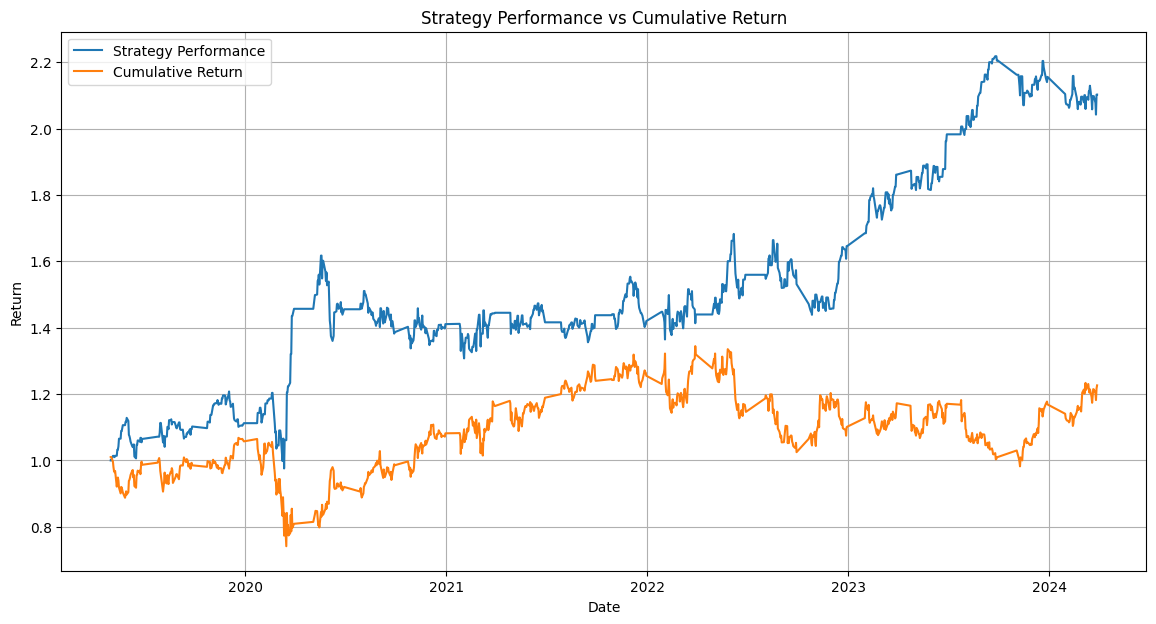

In [ ]:
symbol = 'TXN'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)


## MSFT

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30          23        4.964593
1  2019-07-01 2019-09-30          21        4.069539
2  2019-10-01 2019-12-31          27        4.739003
3  2020-01-01 2020-03-31          12        4.828621
4  2020-04-01 2020-06-30          19        2.537527
5  2020-07-01 2020-09-30          11        1.328445
6  2020-10-01 2020-12-31          10        1.226852
7  2021-01-01 2021-03-31          10        1.226852
8  2021-04-01 2021-06-30          19        1.000000
9  2021-07-01 2021-09-30          10        1.226852
10 2021-10-01 2021-12-31          26        4.389007
11 2022-01-01 2022-03-31          10        1.109714
12 2022-04-01 2022-06-30          12        4.828621
13 2022-07-01 2022-09-30          19        4.377063
14 2022-10-01 2022-12-31          18        4.379322
15 2023-01-01 2023-03-31          19        4.198627
16 2023-04-01 2023-06-30          25        2.508788
17 2023-07-01 2023-09-30          30        2.

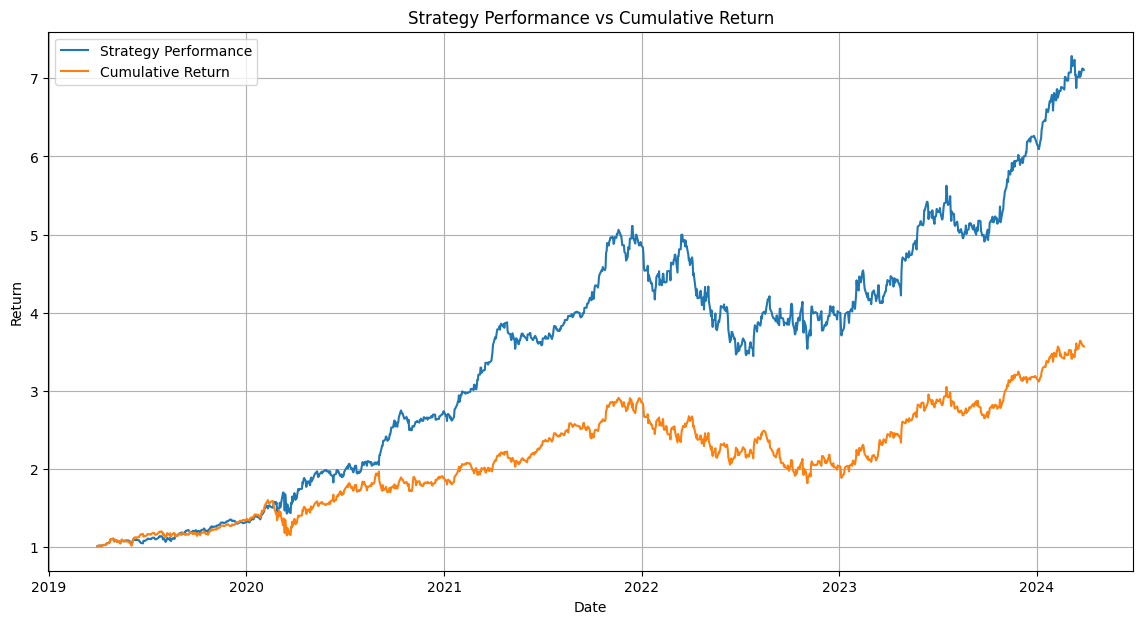

In [ ]:
symbol = 'MSFT'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## AMZN

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30           6        4.480349
1  2019-07-01 2019-09-30          19        4.109669
2  2019-10-01 2019-12-31          19        4.377063
3  2020-01-01 2020-03-31          19        4.377063
4  2020-04-01 2020-06-30          12        4.828621
5  2020-07-01 2020-09-30           3        4.497658
6  2020-10-01 2020-12-31           3        4.176562
7  2021-01-01 2021-03-31          26        4.389007
8  2021-04-01 2021-06-30          18        2.380477
9  2021-07-01 2021-09-30          12        4.915712
10 2021-10-01 2021-12-31          12        2.909324
11 2022-01-01 2022-03-31           8        2.926885
12 2022-04-01 2022-06-30          15        1.272821
13 2022-07-01 2022-09-30          10        2.698371
14 2022-10-01 2022-12-31           6        4.855594
15 2023-01-01 2023-03-31           7        4.440164
16 2023-04-01 2023-06-30           2        2.389405
17 2023-07-01 2023-09-30          21        4.

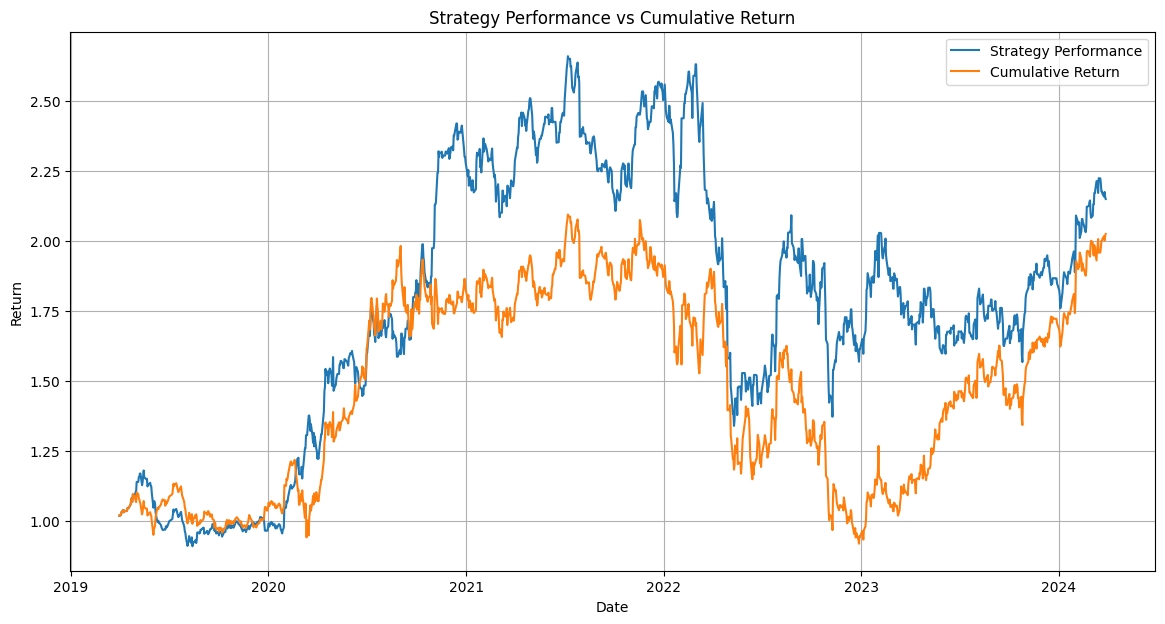

In [ ]:
symbol = 'AMZN'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## CSCO

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30          25        2.502392
1  2019-07-01 2019-09-30          11        3.592687
2  2019-10-01 2019-12-31           9        4.671604
3  2020-01-01 2020-03-31           6        4.480349
4  2020-04-01 2020-06-30          24        2.570818
5  2020-07-01 2020-09-30          29        2.615778
6  2020-10-01 2020-12-31          14        1.973414
7  2021-01-01 2021-03-31          11        1.574127
8  2021-04-01 2021-06-30          30        1.638094
9  2021-07-01 2021-09-30          26        1.497524
10 2021-10-01 2021-12-31          12        1.272610
11 2022-01-01 2022-03-31          24        1.000000
12 2022-04-01 2022-06-30          12        4.828621
13 2022-07-01 2022-09-30          21        1.038885
14 2022-10-01 2022-12-31          20        1.000000
15 2023-01-01 2023-03-31          19        2.479447
16 2023-04-01 2023-06-30          19        4.377063
17 2023-07-01 2023-09-30          19        4.

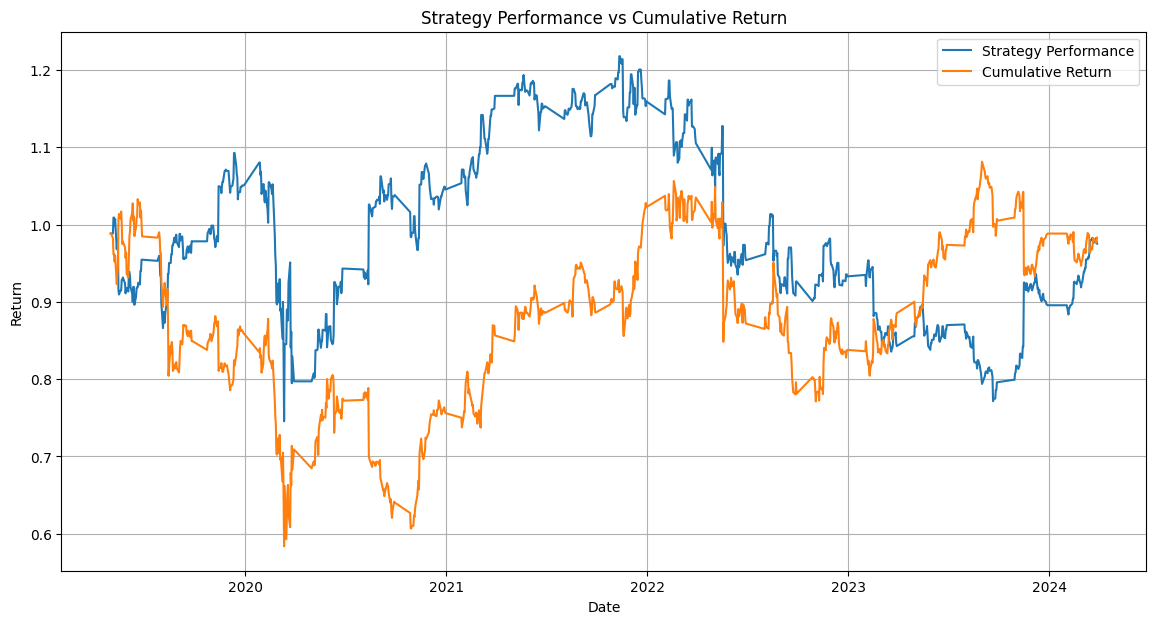

In [ ]:
symbol = 'CSCO'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## ADI

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30          27        3.134807
1  2019-07-01 2019-09-30          22        1.000000
2  2019-10-01 2019-12-31          26        4.219232
3  2020-01-01 2020-03-31          10        3.566981
4  2020-04-01 2020-06-30          26        5.000000
5  2020-07-01 2020-09-30           2        2.894812
6  2020-10-01 2020-12-31          11        3.592687
7  2021-01-01 2021-03-31          25        2.919909
8  2021-04-01 2021-06-30          11        1.222921
9  2021-07-01 2021-09-30          10        1.226852
10 2021-10-01 2021-12-31          12        4.828621
11 2022-01-01 2022-03-31          12        4.828621
12 2022-04-01 2022-06-30          12        4.828621
13 2022-07-01 2022-09-30          13        4.344315
14 2022-10-01 2022-12-31          16        4.558837
15 2023-01-01 2023-03-31          13        4.344315
16 2023-04-01 2023-06-30          12        4.362177
17 2023-07-01 2023-09-30          30        1.

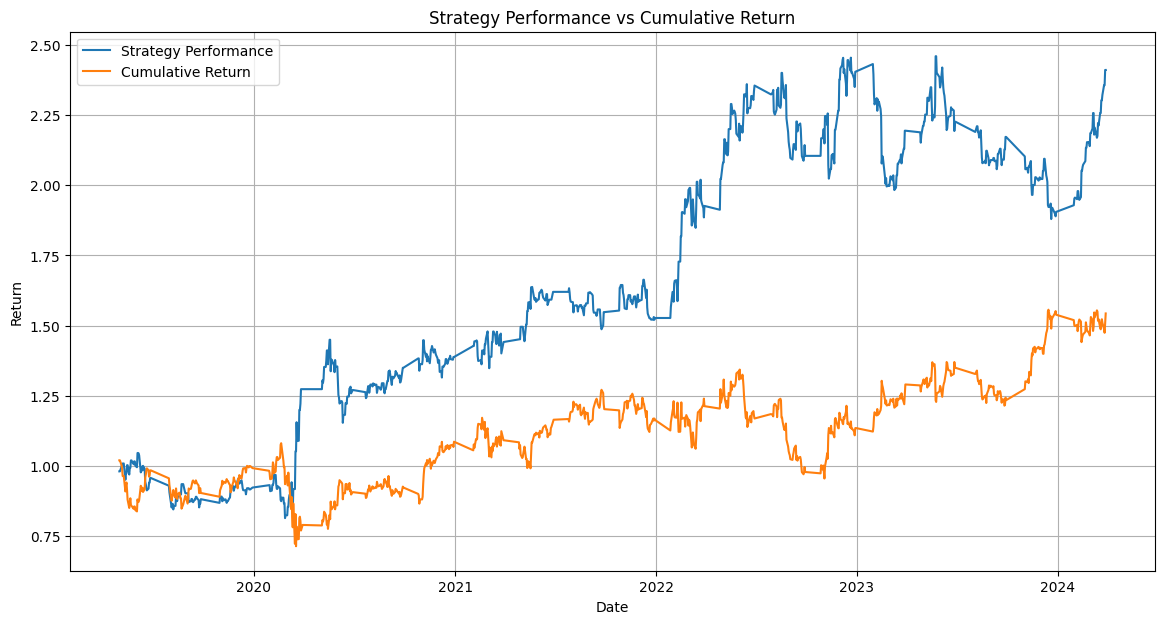

In [ ]:
symbol = 'ADI'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## **Potential Profitability**

- **Tickers:** `['MSFT', 'AMZN', 'CSCO', 'TXN', 'ADI']`
- Compare the average cumulative return of a trading strategy across multiple tickers with the cumulative return of a benchmark(average cumulative return of tickers)



In [ ]:
def execute_combine(symbol, start_date, end_date, train_size, test_size):
    df = fetch_asset_data(symbol, start_date, end_date)
    df['signals'] = np.nan  # Initialize the signals column with NaNs

    for train_start, train_end, test_start, test_end in rolling_window(symbol, start_date, end_date, train_size, test_size):
        signals, best_params = strategy_implement_dynamic(symbol, train_start, train_end, test_start, test_end)
        signals_start_date = signals.index.min().strftime('%Y-%m-%d')
        signals_end_date = signals.index.max().strftime('%Y-%m-%d')

        df.loc[signals_start_date:signals_end_date, 'signals'] = signals['signals']

    df.dropna(inplace=True)
    strategy_results = strategy(df)
    df.merge(strategy_results['position'], left_index=True, right_index=True, how='left')

    df['performance'] = strategy_results['performance']
    calculate_metrics(strategy_results['performance'], symbol)
    df['cum_ret'] = calculate_cumulative_returns(df['Daily Return'])


    return df['performance'],df['cum_ret']

In [ ]:
tickers=['MSFT', 'AMZN', 'CSCO', 'TXN', 'ADI']

In [ ]:
performance_df = pd.DataFrame()
performance_benchmark_df = pd.DataFrame()
for ticker in tickers:
    performance1, performance2  = execute_combine(ticker,start_date,end_date,train_size,test_size)
    performance_df[ticker] = performance1
    performance_benchmark_df[ticker] = performance2

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: MSFT
Total Return: 1.3511456306751444
Annualized Return (APR): 0.2873194544232156
Sharpe Ratio: 1.0291260920389245
Maximum Drawdown: -0.22077780802173852
Maximum Drawdown Duration: 228.0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: AMZN
Total Return: 0.3427814290661608
Annualized Return (APR): 0.08734356699199664
Sharpe Ratio: 0.4254295414302584
Maximum Drawdown: -0.441170061653803
Maximum Drawdown Duration: 377.0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: CSCO
Total Return: -0.013345339366278733
Annualized Return (APR): -0.003947407521378787
Sharpe Ratio: 0.12528260482461973
Maximum Drawdown: -0.36644919133233833
Maximum Drawdown Duration: 414.0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 1.0] before, using random point [24, 3.973261784688413]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 1.0] before, using random point [9, 4.92323770753028]
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%***********

Ticker: TXN
Total Return: 1.1023946352401124
Annualized Return (APR): 0.2350493632927455
Sharpe Ratio: 0.9338376844932286
Maximum Drawdown: -0.19206987460114988
Maximum Drawdown Duration: 367.0



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Ticker: ADI
Total Return: 1.4595171595236185
Annualized Return (APR): 0.29937528037723915
Sharpe Ratio: 0.986984737029807
Maximum Drawdown: -0.23592633991353507
Maximum Drawdown Duration: 145.0


Strategy's performance

In [ ]:
print(performance_df)

                MSFT      AMZN      CSCO       TXN       ADI
Date                                                        
2019-05-02  0.986941  1.051668  0.988485  1.000000  0.980296
2019-05-03  1.007976  1.085772  0.988485  0.999915  0.980380
2019-05-06  1.007976  1.085772  0.988485  1.013619  0.997314
2019-05-07  0.987290  1.102221  1.009127  1.013619  1.008161
2019-05-08  0.987211  1.104074  1.009127  1.013619  1.008161
...              ...       ...       ...       ...       ...
2024-03-22  2.294108  1.369845  0.977878  2.097652  2.321999
2024-03-25  2.325571  1.363412  0.979842  2.077828  2.356557
2024-03-26  2.325571  1.374109  0.982406  2.042073  2.356557
2024-03-27  2.324358  1.362318  0.978045  2.102395  2.411056
2024-03-28  2.320442  1.358151  0.975293  2.102395  2.411056

[853 rows x 5 columns]


Benchmark's performance

In [ ]:
print(performance_benchmark_df)

                MSFT      AMZN      CSCO       TXN       ADI
Date                                                        
2019-05-02  0.986941  0.988070  0.988485  1.010061  1.019704
2019-05-03  1.007976  1.020112  0.988485  1.010147  1.019616
2019-05-06  1.002111  1.013921  0.982188  0.996302  1.002005
2019-05-07  0.981545  0.998560  0.961677  0.979706  0.991107
2019-05-08  0.981467  0.996881  0.962037  0.967925  0.963819
...              ...       ...       ...       ...       ...
2024-03-22  1.652729  0.944857  0.980555  1.213952  1.509805
2024-03-25  1.630062  0.949294  0.978585  1.202480  1.487335
2024-03-26  1.625398  0.941846  0.976024  1.181788  1.474305
2024-03-27  1.624550  0.949928  0.980358  1.216697  1.508401
2024-03-28  1.621813  0.952833  0.983116  1.226129  1.543198

[853 rows x 5 columns]


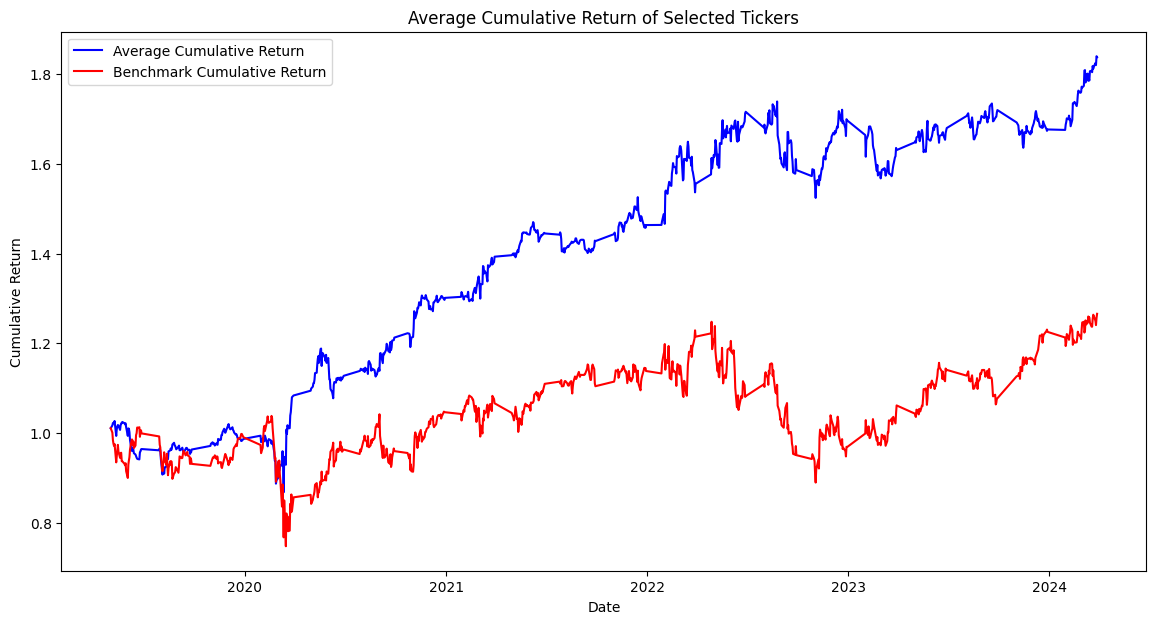

In [ ]:
performance_df.fillna(method='bfill', inplace=True)
performance_benchmark_df.fillna(method='bfill', inplace=True)

cumulative_returns = (performance_df.pct_change() + 1).cumprod() - 1

# Calculate the average cumulative return
average_cumulative_return = cumulative_returns.mean(axis=1)+1

cumulative_returns_benchmark = (performance_benchmark_df.pct_change() + 1).cumprod() - 1

# Calculate the average cumulative return
average_cumulative_return_benchmark = cumulative_returns_benchmark.mean(axis=1)+1

plt.figure(figsize=(14, 7))

plt.plot(average_cumulative_return, label='Average Cumulative Return', color='blue')
plt.plot(average_cumulative_return_benchmark, label='Benchmark Cumulative Return', color='red')
plt.title('Average Cumulative Return of Selected Tickers')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# INDEX PERFORMANCE


## SPY

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30          13        4.344315
1  2019-07-01 2019-09-30           5        1.198900
2  2019-10-01 2019-12-31           8        1.346235
3  2020-01-01 2020-03-31          30        1.000000
4  2020-04-01 2020-06-30          26        4.389007
5  2020-07-01 2020-09-30          13        4.344315
6  2020-10-01 2020-12-31          13        4.344315
7  2021-01-01 2021-03-31          13        4.820917
8  2021-04-01 2021-06-30          15        4.795375
9  2021-07-01 2021-09-30          12        4.828621
10 2021-10-01 2021-12-31          18        1.265131
11 2022-01-01 2022-03-31          29        4.327756
12 2022-04-01 2022-06-30          10        2.875884
13 2022-07-01 2022-09-30           6        2.900741
14 2022-10-01 2022-12-31           2        2.704790
15 2023-01-01 2023-03-31          14        2.862954
16 2023-04-01 2023-06-30           6        2.902065
17 2023-07-01 2023-09-30          25        2.

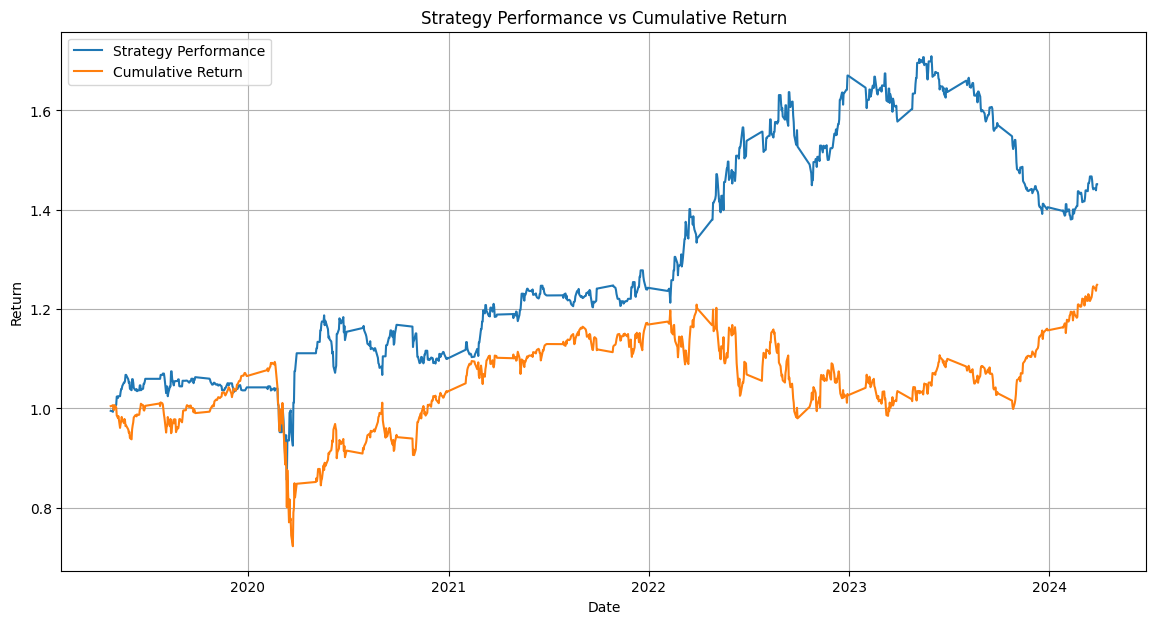

In [ ]:
symbol = '^GSPC'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## QQQ

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30          19        2.537527
1  2019-07-01 2019-09-30          19        2.537527
2  2019-10-01 2019-12-31          19        2.537527
3  2020-01-01 2020-03-31           2        1.709168
4  2020-04-01 2020-06-30          16        5.000000
5  2020-07-01 2020-09-30          13        1.009745
6  2020-10-01 2020-12-31          13        4.344315
7  2021-01-01 2021-03-31          14        4.616478
8  2021-04-01 2021-06-30          13        1.000000
9  2021-07-01 2021-09-30          16        1.843344
10 2021-10-01 2021-12-31          13        1.587402
11 2022-01-01 2022-03-31           2        1.401732
12 2022-04-01 2022-06-30          23        1.779571
13 2022-07-01 2022-09-30          27        3.201894
14 2022-10-01 2022-12-31          29        2.949454
15 2023-01-01 2023-03-31          26        4.389007
16 2023-04-01 2023-06-30           2        2.825931
17 2023-07-01 2023-09-30          25        2.

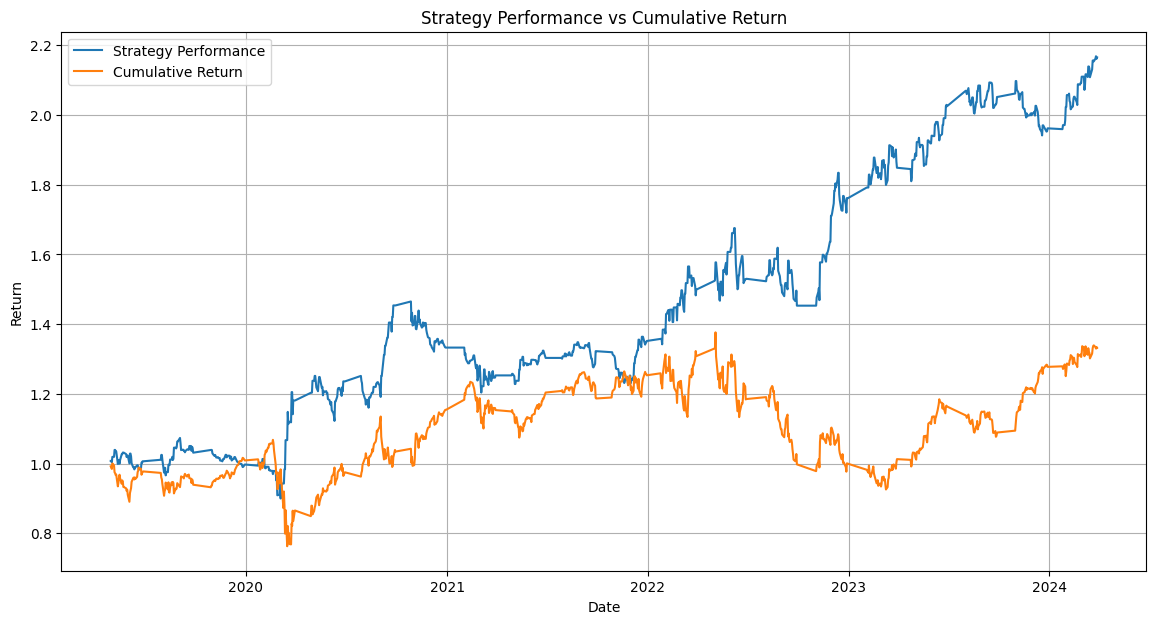

In [ ]:
symbol = 'QQQ'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## DIA

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30           3        1.168889
1  2019-07-01 2019-09-30          15        1.295133
2  2019-10-01 2019-12-31          14        1.274100
3  2020-01-01 2020-03-31          30        1.391634
4  2020-04-01 2020-06-30          18        4.215887
5  2020-07-01 2020-09-30          30        1.013771
6  2020-10-01 2020-12-31          10        1.226852
7  2021-01-01 2021-03-31          13        4.344315
8  2021-04-01 2021-06-30          14        4.584341
9  2021-07-01 2021-09-30          12        4.376298
10 2021-10-01 2021-12-31          13        4.344315
11 2022-01-01 2022-03-31          19        2.537527
12 2022-04-01 2022-06-30           6        4.480349
13 2022-07-01 2022-09-30           6        4.480349
14 2022-10-01 2022-12-31           7        1.380552
15 2023-01-01 2023-03-31           8        1.298171
16 2023-04-01 2023-06-30          12        1.332850
17 2023-07-01 2023-09-30          11        1.

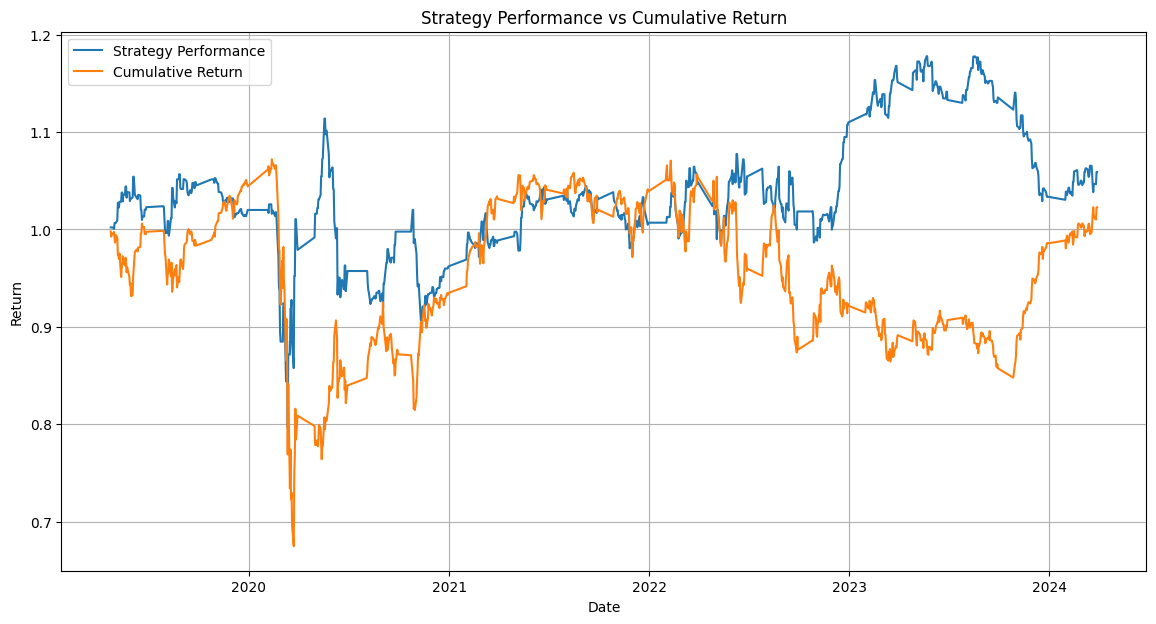

In [ ]:
symbol = 'DIA'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)

## SOXX

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 1.0] before, using random point [25, 2.0131289862932977]
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 1.0] before, using random point [24, 3.973261784688413]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 1.0] before, using random point [9, 4.9

   Start Date   End Date  atr_period  atr_multiplier
0  2019-04-01 2019-06-30           8        1.000000
1  2019-07-01 2019-09-30          10        1.000000
2  2019-10-01 2019-12-31           2        1.000000
3  2020-01-01 2020-03-31          30        1.175362
4  2020-04-01 2020-06-30          25        2.919909
5  2020-07-01 2020-09-30          26        2.572006
6  2020-10-01 2020-12-31          19        2.537527
7  2021-01-01 2021-03-31          23        2.848378
8  2021-04-01 2021-06-30          12        4.828621
9  2021-07-01 2021-09-30          10        1.226852
10 2021-10-01 2021-12-31          30        5.000000
11 2022-01-01 2022-03-31          11        3.592687
12 2022-04-01 2022-06-30          30        1.803695
13 2022-07-01 2022-09-30          30        4.628725
14 2022-10-01 2022-12-31          10        2.765462
15 2023-01-01 2023-03-31          19        2.537527
16 2023-04-01 2023-06-30          19        2.537527
17 2023-07-01 2023-09-30          13        4.

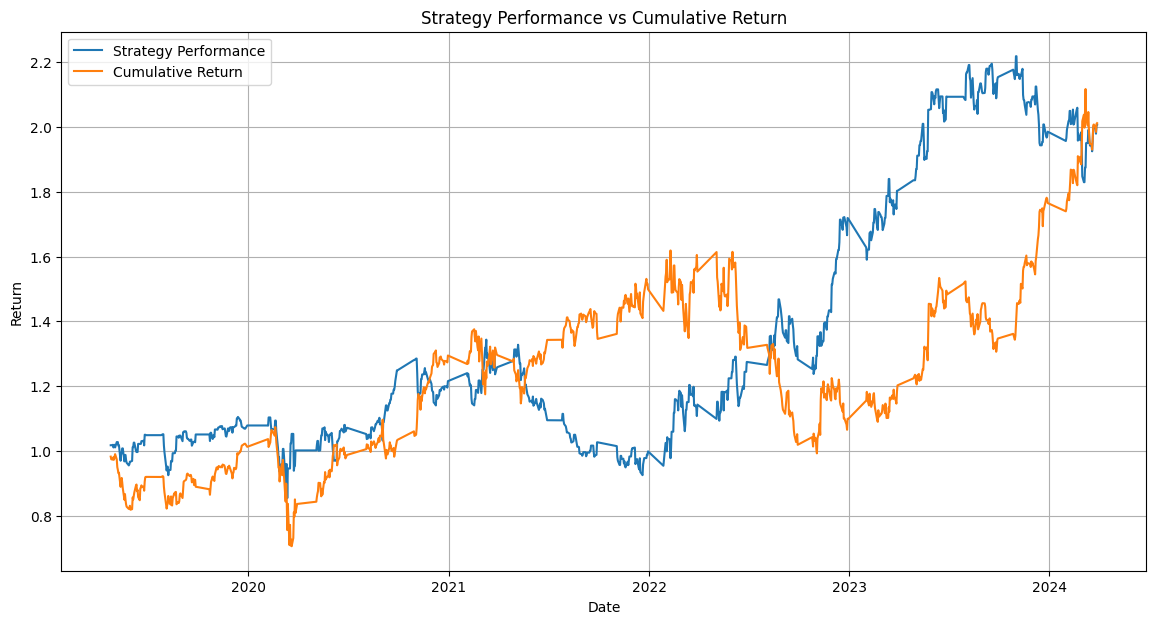

In [ ]:
symbol = 'SOXX'
start_date = '2018-01-01'
end_date = '2024-06-01'
df = execute(symbol,start_date,end_date,train_size,test_size)